In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Precios Fertilizantes

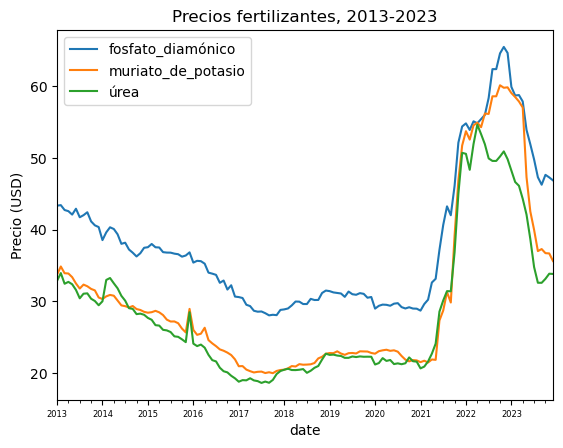

In [83]:
precios_fertilizantes = pd.read_csv('data\precios_fertilizantes.csv', delimiter=';', encoding='latin1')

precios_fertilizantes['date'] = pd.to_datetime(precios_fertilizantes['date'])
precios_fertilizantes.set_index('date', inplace=True)

precios_fertilizantes.plot()
plt.title("Precios fertilizantes, 2013-2023")
plt.ylabel("Precio (USD)")
plt.xticks(size=6)
plt.show()

### Inflación

In [84]:
inf_mensual = pd.read_csv('data\inflación_mensual.csv')

In [85]:
inf_mensual['Inflación mensual general'] = inf_mensual['Inflación mensual general'].str.replace(',', '.')

inf_mensual_nacional = inf_mensual\
    .rename(columns={
        'Mes': 'date',
        'Inflación mensual general': 'inf_mensual'
        })\
    .astype({
        'date': 'datetime64[ns]',
        'inf_mensual': 'float'
        })\
    [inf_mensual['Región'] == 'NACIONAL']\
    .drop(columns=['Año', 'Región'])\
    .set_index('date')

inf_mensual_nacional.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 225 entries, 2005-02-01 to 2023-10-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   inf_mensual  225 non-null    float64
dtypes: float64(1)
memory usage: 3.5 KB


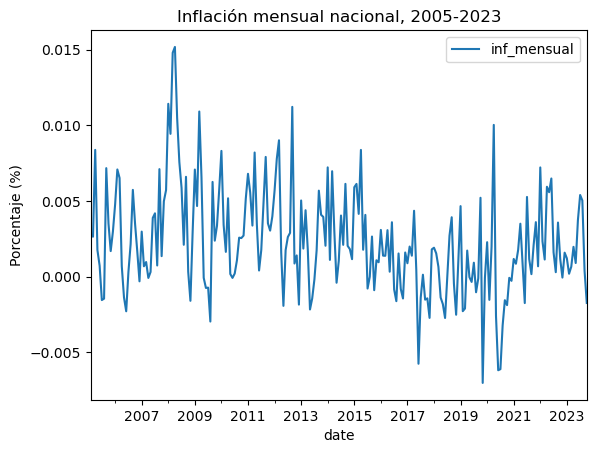

In [86]:
inf_mensual_nacional.plot()
plt.title("Inflación mensual nacional, 2005-2023")
plt.ylabel("Porcentaje (%)")
plt.show()

### Precios combustibles

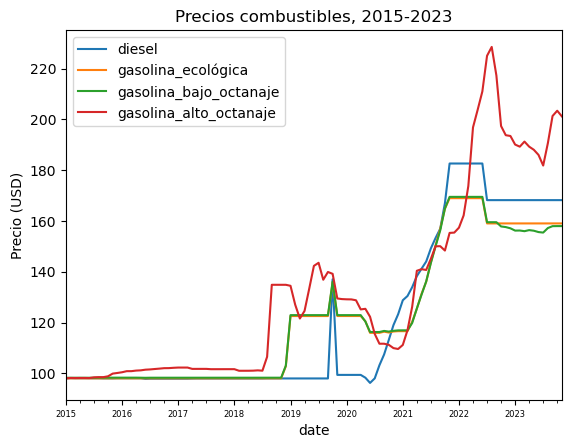

In [87]:
precios_combustibles = pd.read_excel('data\precios-combustibles.xlsx')

precios_combustibles['date'] = pd.to_datetime(precios_combustibles['date'])
precios_combustibles.set_index('date', inplace=True)

precios_combustibles.plot()
plt.title("Precios combustibles, 2015-2023")
plt.ylabel("Precio (USD)")
plt.xticks(size=6)
plt.show()

### Precios WTI

In [109]:
wti_prices = pd.read_excel('data\precios_wti.xlsx')

# Convertir las columnas a formato largo (melt)
wti_prices = wti_prices.melt(
    id_vars=["Year"],
    var_name="Month",value_name="precio_wti"
    )

# Crear la columna 'Fecha' a partir de 'Year' y 'Month'
wti_prices['date'] = pd.to_datetime(wti_prices['Year'].astype(str) + '-' + wti_prices['Month'].str[0:3] + '-01')

# Seleccionar solo las columnas 'Fecha' y 'Price'
wti_prices = wti_prices[['date', 'precio_wti']]

# Ordenar por 'date' y establecer como índice:
wti_prices = wti_prices\
    .sort_values('date')\
    .reset_index(drop=True)\
    .set_index('date')

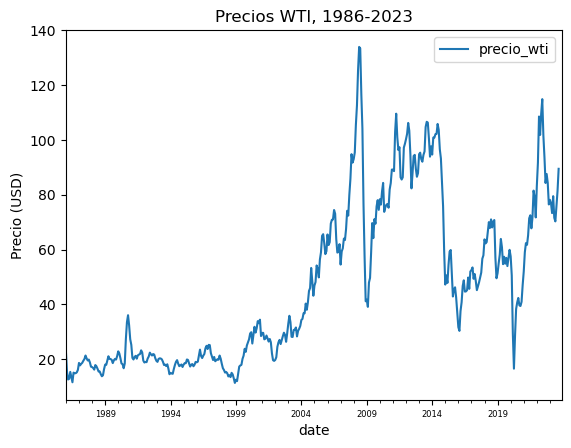

In [111]:
wti_prices.plot()
plt.title("Precios WTI, 1986-2023")
plt.ylabel("Precio (USD)")
plt.xticks(size=6)
plt.show()